In [92]:
import pandas as pd
import numpy as np
import ast
import nltk
import gensim
import time
import pickle
import os
from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
tqdm.pandas()

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Code to run from Colab
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# path_prefix = "/content/gdrive/MyDrive/FoodRec"
# sys.path.insert(1, path_prefix)

# Code to run from CSIL lab machines
recipes = pd.read_csv('./Data/recipes_enriched.csv')
ratings_with_polarity_df = pd.read_csv('./Data/ratings_with_polarity_score.csv')

recipes.head()

[nltk_data] Downloading package stopwords to /home/dkn4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dkn4/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/dkn4/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,name,id,minutes,contributor_id,nutrition,n_steps,steps,ingredients,n_ingredients,cuisine
0,arriba baked winter squash mexican style,137739,55,47892,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...","['winter squash', 'mexican seasoning', 'mixed ...",7,southern_us
1,a bit different breakfast pizza,31490,30,26278,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...","['prepared pizza crust', 'sausage patty', 'egg...",6,italian
2,all in the kitchen chili,112140,130,196586,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...","['ground beef', 'yellow onions', 'diced tomato...",13,mexican
3,alouette potatoes,59389,45,68585,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"['spreadable cheese with garlic and herbs', 'n...",11,french
4,amish tomato ketchup for canning,44061,190,41706,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,southern_us


In [93]:
ratings_mean_df = ratings_with_polarity_df.groupby('recipe_id', as_index=False).mean()

In [94]:
recipes = recipes.merge(ratings_mean_df, left_on='id', right_on='recipe_id')
recipes.drop(columns=['recipe_id'], axis=1, inplace=True)

In [95]:
recipes.head()

,name,id,minutes,contributor_id,nutrition,n_steps,steps,ingredients,n_ingredients,cuisine,rating,polarity_score
0,arriba baked winter squash mexican style,137739,55,47892,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...","['winter squash', 'mexican seasoning', 'mixed ...",7,southern_us,5.0,0.8836
1,a bit different breakfast pizza,31490,30,26278,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...","['prepared pizza crust', 'sausage patty', 'egg...",6,italian,3.5,0.8961
2,all in the kitchen chili,112140,130,196586,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...","['ground beef', 'yellow onions', 'diced tomato...",13,mexican,4.0,0.8838
3,alouette potatoes,59389,45,68585,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"['spreadable cheese with garlic and herbs', 'n...",11,french,4.5,0.9481
4,amish tomato ketchup for canning,44061,190,41706,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,southern_us,5.0,0.9655


In [96]:
features_df = recipes.copy()[['id', 'ingredients', 'cuisine', 'rating', 'polarity_score']]
# recipes['ingredients'] = recipes['ingredients'].str.replace("'", '"')
# recipes['ingredients'] = recipes['ingredients'].apply(ast.literal_eval)
# recipes["ingredients"] = [", ".join(ingredients) for ingredients in recipes.ingredients]
# features_df = recipes[['id', 'ingredients']]
# features_df["ingredients"] = ["  ".join(ingredients) for ingredients in recipes.ingredients]

In [97]:
features_df['ingredients'] = features_df['ingredients'].apply(ast.literal_eval)
features_df["ingredients"] = [" ".join(ingredients) for ingredients in features_df.ingredients]
features_df["ingredients"] = features_df["ingredients"] + " " + features_df["cuisine"]
features_df.head()

,id,ingredients,cuisine,rating,polarity_score
0,137739,winter squash mexican seasoning mixed spice ho...,southern_us,5.0,0.8836
1,31490,prepared pizza crust sausage patty eggs milk s...,italian,3.5,0.8961
2,112140,ground beef yellow onions diced tomatoes tomat...,mexican,4.0,0.8838
3,59389,spreadable cheese with garlic and herbs new po...,french,4.5,0.9481
4,44061,tomato juice apple cider vinegar sugar salt pe...,southern_us,5.0,0.9655


In [98]:
def text_to_wordlist(text, remove_stopwords=True, lemmatize_words=True):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)
    # Optionally, shorten words to their stems
    if lemmatize_words:
        text = text.split()
        lemmatizer = WordNetLemmatizer()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
        text = " ".join(lemmatized_words)
    
    # Return a list of words
    return text

In [99]:
# Lemmatizing the ingredients & cuisine
features_df['ingredients_lemmatized'] = features_df.ingredients.progress_apply(text_to_wordlist)

  0%|          | 0/231637 [00:00<?, ?it/s]

In [100]:
# Load Google's pre-trained Word2Vec model, trained on news articles
# from CSIL lab machine
bdenv_loc = Path('/usr/shared/CMPT/big-data')
bdata = bdenv_loc / 'data'
model = gensim.models.KeyedVectors.load_word2vec_format(
    bdata / 'GoogleNews-vectors-negative300.bin.gz', binary=True)

# from local path 
# model = KeyedVectors.load_word2vec_format('./Model/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [101]:
# Get the list of keys available in the model
vocab_keys = list(model.index_to_key)
len(vocab_keys)

3000000

In [102]:
def text2vec(text):
    return np.mean([model.get_vector(x, norm=True) for x in text.split() if x in vocab_keys], axis=0).reshape(1,-1)

In [103]:
features_df.head()

,id,ingredients,cuisine,rating,polarity_score,ingredients_lemmatized
0,137739,winter squash mexican seasoning mixed spice ho...,southern_us,5.0,0.8836,winter squash mexican seasoning mixed spice ho...
1,31490,prepared pizza crust sausage patty eggs milk s...,italian,3.5,0.8961,prepared pizza crust sausage patty egg milk sa...
2,112140,ground beef yellow onions diced tomatoes tomat...,mexican,4.0,0.8838,ground beef yellow onion diced tomato tomato p...
3,59389,spreadable cheese with garlic and herbs new po...,french,4.5,0.9481,spreadable cheese garlic herb new potato shall...
4,44061,tomato juice apple cider vinegar sugar salt pe...,southern_us,5.0,0.9655,tomato juice apple cider vinegar sugar salt pe...


In [104]:
# Vectorizing ingredients & cuisine
features_df['vectors'] = features_df.ingredients_lemmatized.progress_apply(text2vec)
features_df.head()

  0%|          | 0/231637 [00:00<?, ?it/s]

,id,ingredients,cuisine,rating,polarity_score,ingredients_lemmatized,vectors
0,137739,winter squash mexican seasoning mixed spice ho...,southern_us,5.0,0.8836,winter squash mexican seasoning mixed spice ho...,"[[-0.027151925, 0.03196454, -0.0039806957, 0.0..."
1,31490,prepared pizza crust sausage patty eggs milk s...,italian,3.5,0.8961,prepared pizza crust sausage patty egg milk sa...,"[[-0.060907207, 0.017352609, 0.0328382, 0.0727..."
2,112140,ground beef yellow onions diced tomatoes tomat...,mexican,4.0,0.8838,ground beef yellow onion diced tomato tomato p...,"[[-0.056562055, 0.023733968, 0.032233305, 0.06..."
3,59389,spreadable cheese with garlic and herbs new po...,french,4.5,0.9481,spreadable cheese garlic herb new potato shall...,"[[-0.032955617, 0.023520077, 0.016438512, 0.06..."
4,44061,tomato juice apple cider vinegar sugar salt pe...,southern_us,5.0,0.9655,tomato juice apple cider vinegar sugar salt pe...,"[[-0.028554145, 0.008382635, -0.0063924827, 0...."


In [105]:
# Normalizing the ratings and polarity score columns through column transformer
column_transformer = ColumnTransformer(
    [
     ('ratings_transformer', Normalizer(), ['rating']),
     ('polarity_score_transformer', Normalizer(), ['polarity_score'])
    ],
     remainder='drop')
X = column_transformer.fit_transform(features_df[['rating', 'polarity_score']])

In [106]:
def concat_vectors_with_column_transformer(vector, column_data):
    # vector = np.array(vector)
    vector_reshaped = np.vstack(vector)
    X = np.concatenate((vector_reshaped, column_data),axis=1)
    return X

vectors = np.array(features_df['vectors'].values)
X = concat_vectors_with_column_transformer(vectors, X)

In [107]:
# Saving the data X temporarily in case of any failures
# np.save('./Data/X.npy', X)    

# Loading the saved data X
# X = np.load('./Data/X.npy')

## Elbow and Silhouette analysis for finding optimal cluster size for KMeans

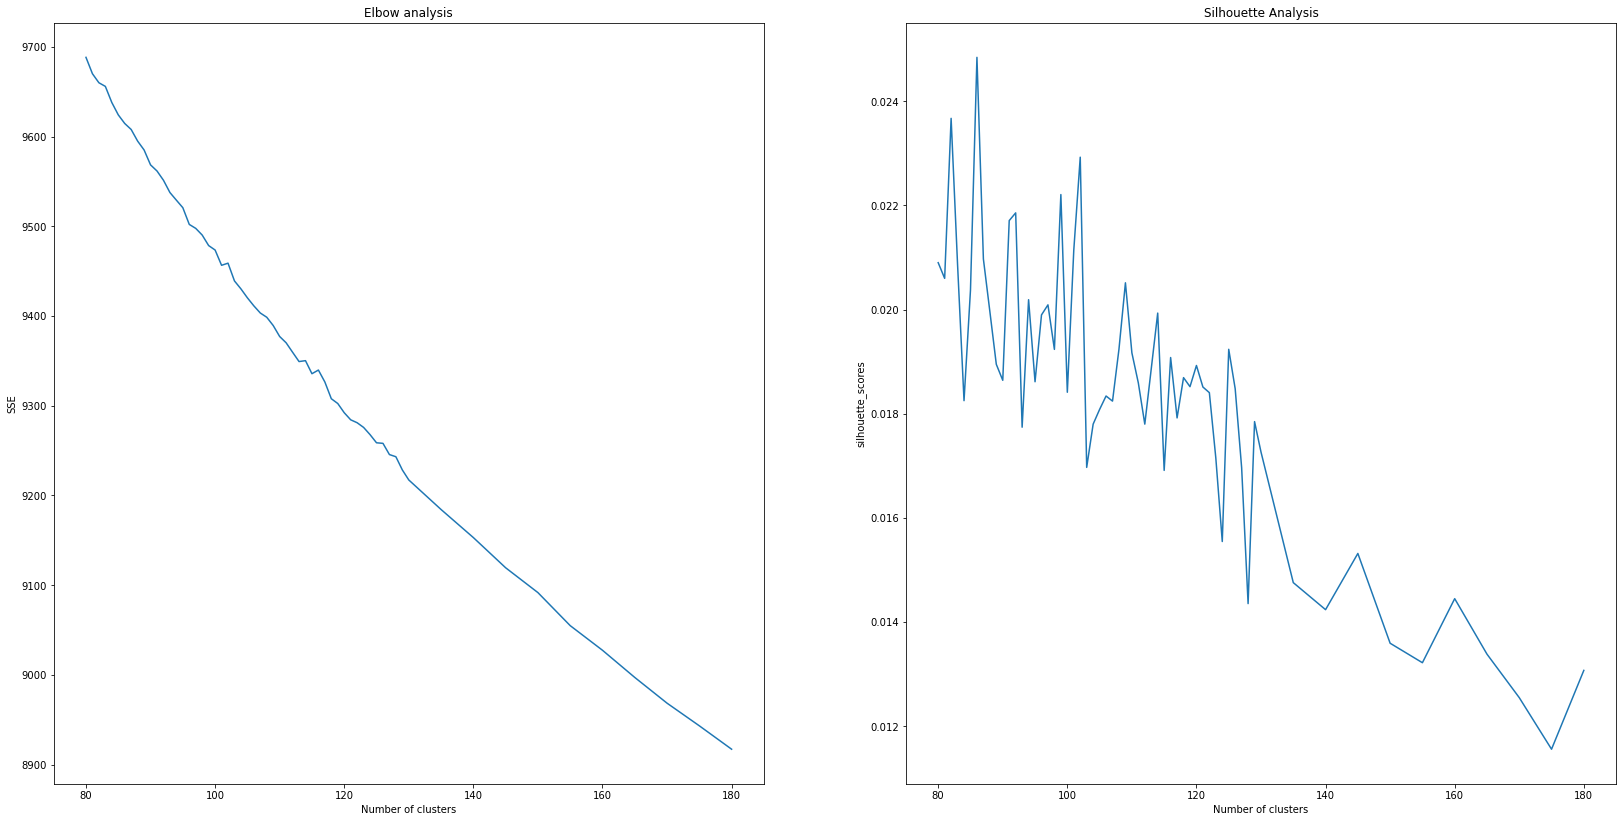

In [108]:
# Continuing after vectorization step
# data-structure to store Sum-Of-Square-Errors
sse = {}
# data-structure to store silhouette scores
silhouette_scores = {}

def plot_kmeans_analysis(sse, silhouette_scores):
    plt.figure(figsize=(28, 14))

    # Plotting the curve with 'k'-value vs SSE
    plt.subplot(1, 2, 1)
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("SSE")
    plt.title("Elbow analysis")
    # Plotting the curve with 'k'-value vs silhouette scores
    plt.subplot(1, 2, 2)
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()))
    plt.xlabel("Number of clusters")
    plt.ylabel("silhouette_scores")
    plt.title("Silhouette Analysis")

    plt.show()


def get_elbow_and_silhouette_analysis(X):
    # Looping over multiple values of k from 80 to 180
    for k in range(80, 180):
        start = time.time()
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100).fit(X)
        labels = kmeans.labels_
        sse[k] = kmeans.inertia_
        silhouette_scores[k] = silhouette_score(X, labels)
        print(f"Completed KMeans with cluster size: {k} & got inertia of {sse[k]} in time {time.time() - start}")
        print(f"Completed KMeans with cluster size: {k} & got silhouette score of {silhouette_scores[k]} in time {time.time() - start}")
    return sse, silhouette_scores

# Analysing the best value of k with elbow and silhouette analysis
sse, silhouette_scores = get_elbow_and_silhouette_analysis(X)

# Plotting the sse and silhouette_analysis values against 'k' value
plot_kmeans_analysis(sse, silhouette_scores)
cluster_size = max(silhouette_scores, key=silhouette_scores.get)

## Building KMeans based on 'k' cluster value from Elbow and silhouette analysis

In [109]:
kmeans_model = KMeans(n_clusters=cluster_size, init='k-means++', max_iter=500, n_init=15)
kmeans_model.fit(X)

KMeans(max_iter=500, n_clusters=86, n_init=15)

In [110]:
features_df["clusters"] = kmeans_model.labels_

In [111]:
features_df.head()

,id,ingredients,cuisine,rating,polarity_score,ingredients_lemmatized,vectors,clusters
0,137739,winter squash mexican seasoning mixed spice ho...,southern_us,5.0,0.8836,winter squash mexican seasoning mixed spice ho...,"[[-0.027151925, 0.03196454, -0.0039806957, 0.0...",32
1,31490,prepared pizza crust sausage patty eggs milk s...,italian,3.5,0.8961,prepared pizza crust sausage patty egg milk sa...,"[[-0.060907207, 0.017352609, 0.0328382, 0.0727...",57
2,112140,ground beef yellow onions diced tomatoes tomat...,mexican,4.0,0.8838,ground beef yellow onion diced tomato tomato p...,"[[-0.056562055, 0.023733968, 0.032233305, 0.06...",61
3,59389,spreadable cheese with garlic and herbs new po...,french,4.5,0.9481,spreadable cheese garlic herb new potato shall...,"[[-0.032955617, 0.023520077, 0.016438512, 0.06...",0
4,44061,tomato juice apple cider vinegar sugar salt pe...,southern_us,5.0,0.9655,tomato juice apple cider vinegar sugar salt pe...,"[[-0.028554145, 0.008382635, -0.0063924827, 0....",27


## Save the features & model for prediction from UI

In [112]:
features_df.to_csv('./Data/features_clustered.csv', columns=['id','ingredients','cuisine','rating','polarity_score','clusters'], index=False)
model_save_path = './Model/kmeans_model.pkl'

with open(model_save_path, 'wb+') as f:
    pickle.dump(kmeans_model, f)

## Sample prediction

In [113]:
# from sklearn.pipeline import Pipeline
# ingredients = ['soy sauce', 'rice', 'vinegar', 'sesame oil', 'wasabe powder', 'water']
ingredients = ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
ingredients = " ".join(ingredients)
lemmatized = text_to_wordlist(ingredients)
vectorized = text2vec(lemmatized)
dict_data = {'rating': [3.0], 'polarity_score': [0.854]}

ratings_df = pd.DataFrame.from_dict(dict_data)
input_x = column_transformer.fit_transform(ratings_df[['rating', 'polarity_score']])
data_x = concat_vectors_with_column_transformer(vectorized, input_x)
# ingredients_pipeline = Pipeline(steps=[('lemmatizer', text_to_wordlist()), ('vectorizer', text2vec())])

In [114]:
predicted_cluster = kmeans_model.predict(data_x)

In [115]:
if predicted_cluster.size != 0:
    predicted_recipes_cluster = features_df[features_df['clusters'] == predicted_cluster[0]]
else:
    print("unable to find similar items")

In [116]:
predicted_recipes_cluster.sample(n=10)

,id,ingredients,cuisine,rating,polarity_score,ingredients_lemmatized,vectors,clusters
102659,82468,vegetable oil onion garlic all-purpose flour m...,mexican,4.666667,0.880300,vegetable oil onion garlic all-purpose flour m...,"[[-0.02969796, 0.019473072, 0.014454206, 0.055...",32
28011,456869,vegetable oil onion garlic clove long-grain ri...,mexican,5.000000,0.929150,vegetable oil onion garlic clove long-grain ri...,"[[-0.044025447, 0.021457255, 0.008893055, 0.05...",32
222444,268535,sweet potato parsnip carrot russet potatoes ic...,filipino,5.000000,0.929900,sweet potato parsnip carrot russet potato ice ...,"[[-0.037642792, 0.060391188, 0.017149854, 0.06...",32
84769,65735,fresh spinach canola oil garlic rice wine salt...,italian,4.500000,0.747125,fresh spinach canola oil garlic rice wine salt...,"[[-0.038911957, 0.032748487, 0.013512075, 0.05...",32
34641,32441,onion tomatoes garlic potatoes rice fresh cila...,spanish,4.371429,0.783694,onion tomato garlic potato rice fresh cilantro...,"[[-0.0387655, 0.036850095, 0.021900643, 0.0497...",32
212647,176787,tomatoes eggs scallions garlic black pepper sa...,chinese,5.000000,0.843900,tomato egg scallion garlic black pepper salt p...,"[[-0.045774013, 0.01937473, 0.018988589, 0.052...",32
10143,360756,turnips olive oil kosher salt chili powder chi...,chinese,4.333333,0.722433,turnip olive oil kosher salt chili powder chinese,"[[-0.030552581, -0.0008272941, 0.024328498, 0....",32
22511,207860,free-range eggs salt dry mustard white vinegar...,southern_us,4.000000,0.592350,free-range egg salt dry mustard white vinegar ...,"[[-0.01534336, 0.047172576, 0.002170626, 0.028...",32
175414,482652,chickpeas sea salt olive oil garam masala indian,indian,4.166667,0.693267,chickpea sea salt olive oil garam masala indian,"[[-0.010349097, 0.019554116, 0.0024247058, 0.0...",32
190354,93325,potatoes oil medium cheddar salt pepper british,british,4.000000,0.636500,potato oil medium cheddar salt pepper british,"[[-0.043930743, 0.049557302, 0.0004079882, 0.0...",32
